In [33]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random 
from PIL import Image
import pandas as pd


import warnings
warnings.filterwarnings("ignore")


# Read the required data

In [34]:
train_path = r"semantic_drone_dataset/training_set/images/"
mask_path = r"semantic_drone_dataset/training_set/gt/semantic/label_images/"
label_path = r"semantic_drone_dataset/training_set/gt/semantic/class_dict.csv"


def importing_data(path):
    sample = []
    train_files_names = [path + item for item in sorted(os.listdir(path))]
    for filename in train_files_names:
        img = Image.open(filename,'r')
        img = img.resize((256,256))
        img = np.array(img)
        sample.append(img)  
    return sample

data_train   = importing_data(train_path)
data_train = np.asarray(data_train)



data_mask   = importing_data(mask_path)
data_mask  = np.asarray(data_mask)



labels = pd.read_csv(label_path).iloc[:, 1:].values


In [35]:
data_train.shape

(400, 256, 256, 3)

# Random visualization of one sample

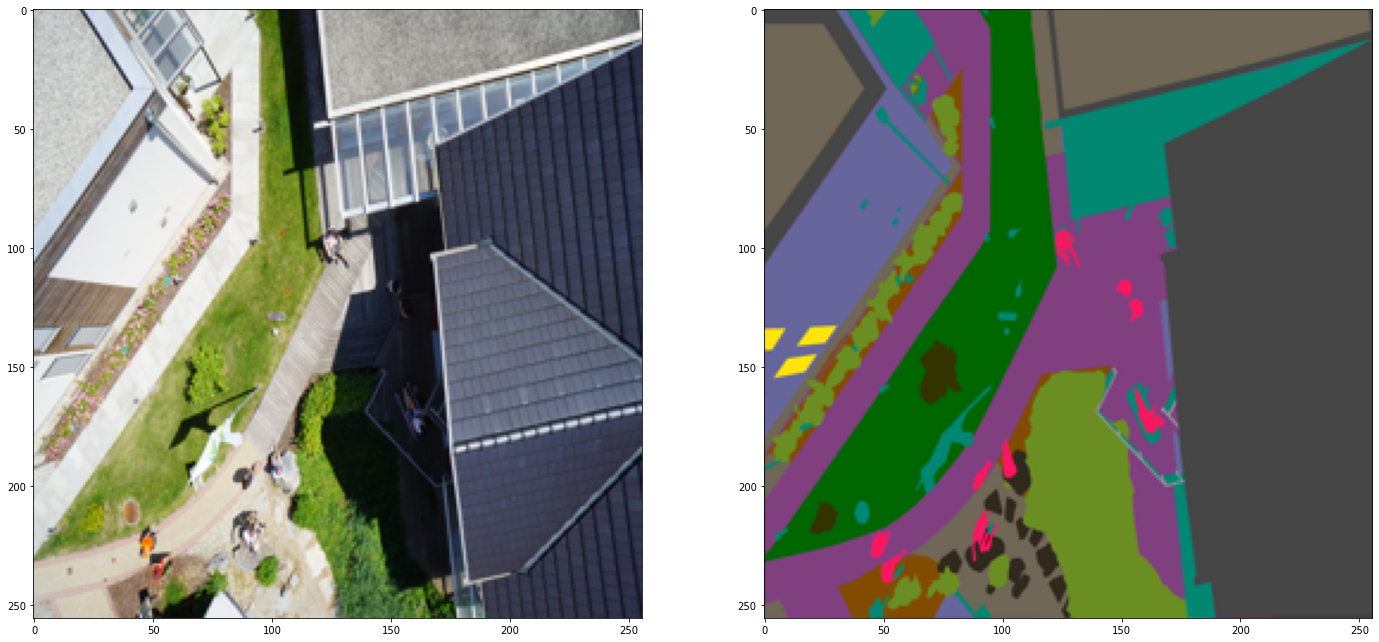

In [36]:
x = random.randint(0, len(data_train))
plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
plt.imshow(data_train[x])
plt.subplot(1,2,2)
plt.imshow(data_mask[x])
plt.show()

# Now I will normalize the images

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
nsamples, nx, ny, nz = data_train.shape
d2_data_train = data_train.reshape((nsamples,nx*ny*nz))
train_images = scaler.fit_transform(d2_data_train)
train_images = train_images.reshape(400,256,256,3)

# Multihot vectorization of the labels

In [38]:
def multihot_vectorization(label):
    image_labels = np.zeros(label.shape, dtype=np.uint8)
    for i in range(24):
        image_labels [np.all(label == labels[i,:],axis=-1)] = i
    image_labels = image_labels[:,:,0]
    return image_labels
    

label_final = []
for i in range(data_mask.shape[0]):
    label = multihot_vectorization(data_mask[i])
    label_final.append(label)    

label_final = np.array(label_final)  

In [39]:
label_final

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  8, ...,  0,  0,  0],
        [ 0,  0,  8, ...,  1,  1,  0],
        ...,
        [ 0,  0,  1, ...,  1,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  3,  0,  0],
        [ 0,  0,  0, ...,  3,  0,  0],
        [ 0,  0, 13, ...,  3,  0,  0],
        ...,
        [ 0,  9,  9, ..., 20, 20, 20],
        [ 0,  9,  9, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  8,  8, ...,  0,  0,  0],
        [ 0,  8,  8, ..., 19,  0,  0],
        [ 0,  0,  8, ..., 19,  0,  0],
        ...,
        [ 1,  1,  1, ...,  2,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[ 0,  0,  8, ...,  2,  0,  0],
        [ 0,  0,  8, ...,  2,  0,  0],
        [ 0,  0,  8, ...,  2,  0,  0],
        ...,
        [ 1,  1,  1, ...,  3,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

# Create the training dataset

In [40]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

n_classes = len(np.unique(label_final))
labels_cat = to_categorical(label_final, num_classes=n_classes)
x_train, x_test, y_train, y_test = train_test_split(train_images, labels_cat, test_size = 0.20, random_state = 42)


In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

def encoder(inputs):
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)  
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)  
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
     
    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
     
    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.2)(conv_4)
    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    return conv_4, conv_3, conv_2, conv_1


def decoder(conv_4, conv_3, conv_2, conv_1):
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_4)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_6)
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)  
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
    return conv_9

In [49]:
def encoder_decoder_simple(n_classes=2, height=256, width=256, channels=3):
    inputs = Input((height, width, channels))

    # Encoding Path
    conv_4, conv_3, conv_2, conv_1 = encoder(inputs)
    
    # Decoding Path
    decoded = decoder(conv_4, conv_3, conv_2, conv_1)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(decoded)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Compile the model and get summary

In [50]:
img_height = x_train.shape[1]
img_width  = x_train.shape[2]
img_channels = x_train.shape[3]


metrics=['accuracy']

print(img_height, img_width, img_channels, n_classes)


model = encoder_decoder_simple(n_classes = n_classes, height=img_height, 
                           width=img_width, channels=img_channels)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

256 256 3 23
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_91 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 dropout_44 (Dropout)        (None, 256, 256, 16)      0         
                                                                 
 conv2d_92 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 128, 128, 32)      4640      
                                              

# Fit the model

In [51]:
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(x_test, y_test), 
                    shuffle=False)

Epoch 1/100


2022-06-18 13:04:21.509759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.0222 - accuracy: 0.0798

2022-06-18 13:04:39.550638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 20s 797ms/step - loss: 3.0222 - accuracy: 0.0798 - val_loss: 2.9016 - val_accuracy: 0.2044
Epoch 2/100
20/20 [==============================] - 15s 750ms/step - loss: 2.6211 - accuracy: 0.2613 - val_loss: 2.5343 - val_accuracy: 0.3357
Epoch 3/100
20/20 [==============================] - 15s 760ms/step - loss: 2.2937 - accuracy: 0.3163 - val_loss: 2.0954 - val_accuracy: 0.3398
Epoch 4/100
20/20 [==============================] - 15s 751ms/step - loss: 2.1446 - accuracy: 0.3259 - val_loss: 2.0253 - val_accuracy: 0.3401
Epoch 5/100
20/20 [==============================] - 16s 809ms/step - loss: 2.0684 - accuracy: 0.3315 - val_loss: 1.9589 - val_accuracy: 0.3405
Epoch 6/100
12/20 [=================>............] - ETA: 7s - loss: 2.0014 - accuracy: 0.3481

KeyboardInterrupt: 

# Visualize the performance of the model

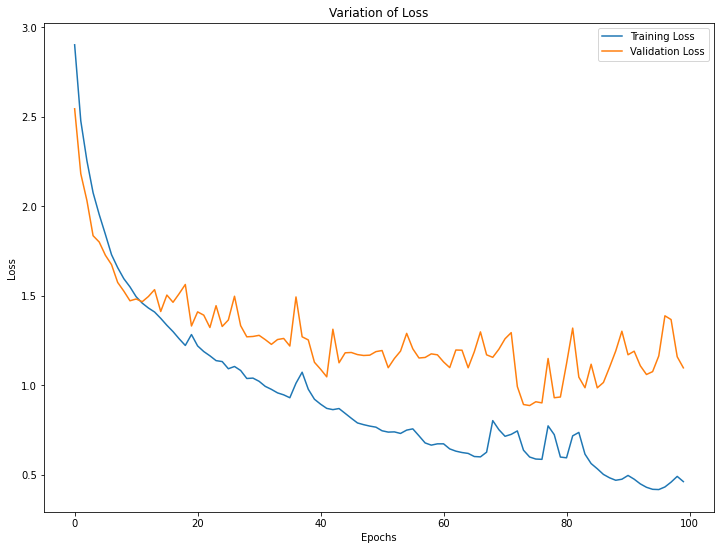

In [30]:
plt.figure(figsize = (12, 9))

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Variation of Loss')
plt.legend()

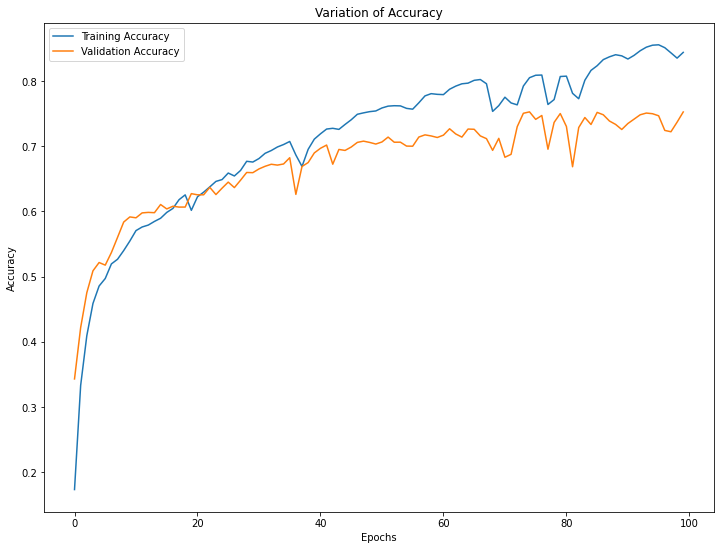

In [32]:
plt.figure(figsize = (12, 9))

plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Variation of Accuracy')
plt.legend()

# Now I will visualise some predictions against the ground truth

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


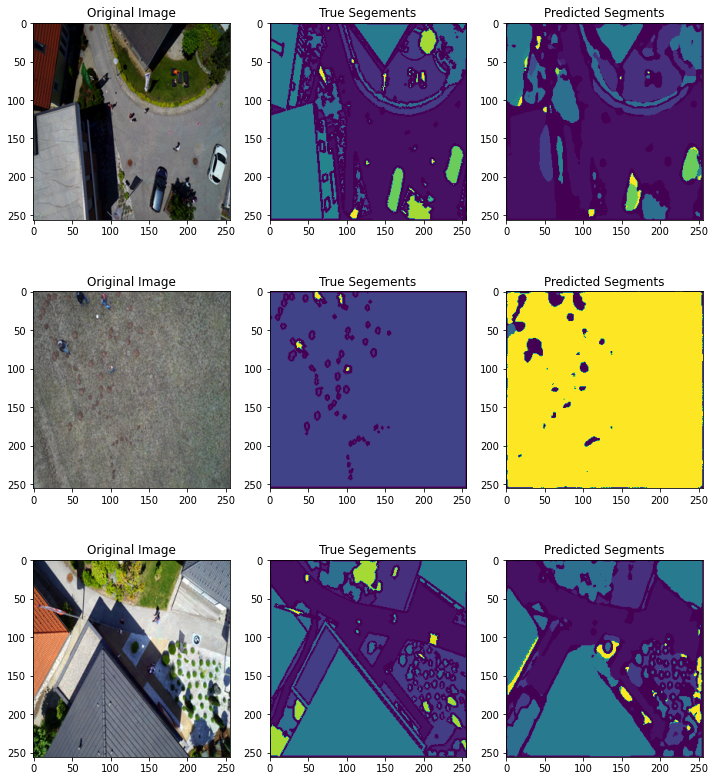

In [36]:
y_pred=model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

fig, axes = plt.subplots(3, 3, figsize = (12,14))
for i in range(3):
    random_index = random.randint(0, len(x_test))
    img = x_test[random_index]
    y_true = y_test_argmax[random_index] 
    test_img_input = np.expand_dims(img, 0) 
    img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:] 
    vals = [img, y_true, img_pred]
    labels_vals = ["Original Image", "True Segements", "Predicted Segments"]
    for j in range(3):   
        
        axes[i,j].imshow(vals[j])
        axes[i,j].set_title(labels_vals[j])
    
plt.show()